In [2]:
import pyemu
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import flopy as fp
from flopy.utils.reference import SpatialReference
import os
import sys
from shutil import copyfile
import fileinput

sys.path.append("../../modules")
# hand made functions
from Rouss import *

In [3]:
ws = "workspace"
m_n_i = "pest_3d_r"
m_n = "pest_3D_R"

case = "3D_test"

In [4]:
sim = fp.mf6.MFSimulation.load(sim_ws=ws)
m = sim.get_model(m_n_i)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package oc...
    loading package npf...
    loading package wel...
    loading package rch...
    loading package rch...
    loading package rch...
    loading package wel...
    loading package chd...
    loading package chd...
    loading package drn...
    loading package riv...
    loading package riv...
    loading package riv...
    loading package riv...
    loading package riv...
    loading package riv...
    loading package obs...
  loading ims package pest_3d_r...


In [5]:
sr = SpatialReference(delr=m.dis.delr.array, delc=m.dis.delc.array, xll=m.dis.xorigin.array, yll=m.dis.yorigin.array)
sr

xul:664525; yul:6207475; rotation:0; proj4_str:None; units:meters; lenuni:2; length_multiplier:1.0

In [6]:
# empty pst object
template_ws = "template"
pf = pyemu.prototypes.PstFrom(original_d=ws, new_d=template_ws,
                 remove_existing=True,
                 longnames=True, spatial_reference=sr,
                 zero_based=False)

2020-07-19 13:22:22.697937 starting: opening PstFrom.log for logging
2020-07-19 13:22:22.697937 starting PstFrom process
2020-07-19 13:22:22.700938 starting: setting up dirs
2020-07-19 13:22:22.701936 starting: removing existing new_d 'template'
2020-07-19 13:22:22.736936 finished: removing existing new_d 'template' took: 0:00:00.035000
2020-07-19 13:22:22.736936 starting: copying original_d 'workspace' to new_d 'template'
2020-07-19 13:22:22.866932 finished: copying original_d 'workspace' to new_d 'template' took: 0:00:00.129996
2020-07-19 13:22:22.868932 finished: setting up dirs took: 0:00:00.167994


In [7]:
#add observation
#Quat
df = pd.read_csv(os.path.join(template_ws,"heads_q.csv"),index_col=0)
hds_df = pf.add_observations("heads_q.csv",insfile="heads_q.csv.ins",index_cols="time",
                use_cols=list(df.columns.values),prefix="quat",obsgp=True)
#P
df = pd.read_csv(os.path.join(template_ws,"heads_pc.csv"),index_col=0)
hds_df = pf.add_observations("heads_pc.csv",insfile="heads_pc.csv.ins",index_cols="time",
                use_cols=list(df.columns.values),prefix="pc",obsgp=True)

#Q map
file = "heads_map_q.csv"
df = pd.read_csv(os.path.join(template_ws,file),index_col=0)
hds_df = pf.add_observations(file,insfile="{}.ins".format(file),index_cols="time",
                use_cols=list(df.columns.values),prefix="qmap",obsgp=True)

pf.obs_dfs[2].weight = 0.5 # set a weaker weigth to these points

2020-07-19 13:22:22.900930 starting: adding observations from tabular output file
2020-07-19 13:22:22.900930 starting: reading list template\heads_q.csv
2020-07-19 13:22:22.909930 finished: reading list template\heads_q.csv took: 0:00:00.009000
2020-07-19 13:22:22.910930 starting: building insfile for tabular output file heads_q.csv
2020-07-19 13:22:22.935929 finished: building insfile for tabular output file heads_q.csv took: 0:00:00.024999
2020-07-19 13:22:22.936930 starting: adding observation from instruction file 'template\heads_q.csv.ins'
2020-07-19 13:22:22.956928 finished: adding observation from instruction file 'template\heads_q.csv.ins' took: 0:00:00.019998
2020-07-19 13:22:22.959928 finished: adding observations from tabular output file took: 0:00:00.058998
2020-07-19 13:22:22.967928 starting: adding observations from tabular output file
2020-07-19 13:22:22.968928 starting: reading list template\heads_pc.csv
2020-07-19 13:22:22.975928 finished: reading list template\heads_p

In [8]:
def chInsfle(file):
    
    """
    change a ins file create with PstFrom (only for a model with 1 stress period)
    in the right format to be used by PEST
    """
    
    fileout = "tmp"
    with open(file) as f:
        with open(fileout,"w") as fout:
            for i,line in enumerate(f):
                if i < 2:
                    fout.write(line)
                if i > 1:
                    for o,split in enumerate(line.split("w")):
                        if o == 1:
                            fout.write("~,~")
                        fout.write(split)
                        
    from shutil import copyfile
    copyfile(fileout, file) # copy 
    os.remove(fileout) # delete tmp file

chInsfle("template/heads_pc.csv.ins")
chInsfle("template/heads_q.csv.ins")
chInsfle("template/heads_map_q.csv.ins")

pf.obs_dfs[0].obgnme = "Quat"
pf.obs_dfs[1].obgnme = "Pc"
pf.obs_dfs[2].obgnme = "Qmap"

In [9]:
pf.build_pst("{}.pst".format(case))

noptmax:30, npar_adj:0, nnz_obs:222


### Parameters

C:\Users\emmal\Anaconda3\lib\site-packages\pyemu\utils\geostats.py:244: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)


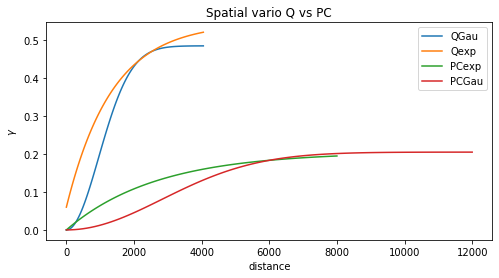

In [10]:
fig,ax = plt.subplots(figsize=(8,4))

#q
vq1 = pyemu.geostats.GauVario(a=1350,contribution=0.485)
vq2 = pyemu.geostats.ExpVario(a=1350,contribution=0.485)
grid_q1 = pyemu.geostats.GeoStruct(variograms=vq1, transform='log')
grid_q2 = pyemu.geostats.GeoStruct(variograms=vq2,nugget=0.06 , transform='log')
b=grid_q1.plot()
b=grid_q2.plot()

#pc
vp2 = pyemu.geostats.ExpVario(a=4000/1.5,contribution=0.205)
vp1 = pyemu.geostats.GauVario(a=4000,contribution=0.205)
grid_pc2 = pyemu.geostats.GeoStruct(variograms=vp1, transform='log')
grid_pc1 = pyemu.geostats.GeoStruct(variograms=vp2, transform='log')
a=grid_pc1.plot()
a=grid_pc2.plot()

a.set_title("Spatial vario Q vs PC")
plt.legend(["QGau","Qexp","PCexp","PCGau"])

In [11]:
## pp quat
zq = m.dis.idomain.array[1] # zone array for pp
zq[:,140:]=0
zq[zq<0]=0
#plt.imshow(zq)
pf.add_parameters(filenames="kq.txt",par_type="pilotpoint",pp_space=6,zone_array=zq,
                   par_name_base="kp_q",pargp="pp_q",
                   upper_bound=5,lower_bound=0.005,ult_ubound=5e-3,ult_lbound=1e-5,geostruct=grid_q2)

2020-07-19 13:22:24.173892 starting: adding pilotpoint type multiplier style parameters for file(s) ['kq.txt']
2020-07-19 13:22:24.178891 starting: loading array template\kq.txt
2020-07-19 13:22:24.248889 finished: loading array template\kq.txt took: 0:00:00.069998
2020-07-19 13:22:24.249889 loaded array 'kq.txt' of shape (182, 183)
2020-07-19 13:22:24.331887 starting: writing array-based template file 'kp_q_inst0_pilotpoint.csv.tpl'
2020-07-19 13:22:24.332886 starting: setting up pilot point parameters
2020-07-19 13:22:24.333886 No spatial reference (containing cell spacing) passed.
2020-07-19 13:22:24.333886 OK - using spatial reference in parent object.
2020-07-19 13:22:25.534849 224 pilot point parameters created
2020-07-19 13:22:25.536854 pilot point 'pargp':kp_q_inst:0
2020-07-19 13:22:25.536854 finished: setting up pilot point parameters took: 0:00:01.203968
2020-07-19 13:22:25.617846 starting: calculating factors for pargp=kp_q_inst:0
2020-07-19 13:22:25.618846 saving krige var

In [12]:
## pp pc
zpc = m.dis.idomain.array[3] # zone array for pp
zpc[:,140:]=0
zpc[zpc<0]=0
#plt.imshow(zpc)

pf.add_parameters(filenames="kpc.txt",par_type="pilotpoint",pp_space=6,zone_array=zpc,
                   par_name_base="kp_pc",pargp="pp_pc",
                   upper_bound=30,lower_bound=0.1,ult_ubound=1e-3,ult_lbound=1e-6,geostruct=grid_pc2)

2020-07-19 13:23:43.322428 starting: adding pilotpoint type multiplier style parameters for file(s) ['kpc.txt']
2020-07-19 13:23:43.323428 starting: loading array template\kpc.txt
2020-07-19 13:23:43.392426 finished: loading array template\kpc.txt took: 0:00:00.068998
2020-07-19 13:23:43.392426 loaded array 'kpc.txt' of shape (182, 183)
2020-07-19 13:23:43.471424 starting: writing array-based template file 'kp_pc_inst0_pilotpoint.csv.tpl'
2020-07-19 13:23:43.472424 starting: setting up pilot point parameters
2020-07-19 13:23:43.473422 No spatial reference (containing cell spacing) passed.
2020-07-19 13:23:43.473422 OK - using spatial reference in parent object.
2020-07-19 13:23:44.970376 293 pilot point parameters created
2020-07-19 13:23:44.972376 pilot point 'pargp':kp_pc_inst:0
2020-07-19 13:23:44.972376 finished: setting up pilot point parameters took: 0:00:01.499952
2020-07-19 13:23:45.072373 starting: calculating factors for pargp=kp_pc_inst:0
2020-07-19 13:23:45.073372 saving kr

2020-07-19 13:25:09.457746 starting: adding zone type multiplier style parameters for file(s) ['irr.txt']
2020-07-19 13:25:09.458746 starting: loading array template\irr.txt
2020-07-19 13:25:09.511744 finished: loading array template\irr.txt took: 0:00:00.052998
2020-07-19 13:25:09.511744 loaded array 'irr.txt' of shape (182, 183)
2020-07-19 13:25:09.567742 starting: writing array-based template file 'irr_inst0_zone.csv.tpl'
2020-07-19 13:25:09.568743 starting: writing template file irr_inst0_zone.csv.tpl for ['irr_inst:0']
2020-07-19 13:25:09.724737 finished: writing template file irr_inst0_zone.csv.tpl for ['irr_inst:0'] took: 0:00:00.155994
2020-07-19 13:25:09.725738 finished: writing array-based template file 'irr_inst0_zone.csv.tpl' took: 0:00:00.157996
2020-07-19 13:25:09.749738 starting: adding parameters for file(s) ['irr.txt']


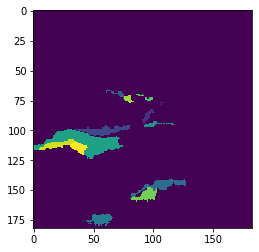

In [13]:
#irri
zi = np.loadtxt(os.path.join(ws,"zone_irr.txt"))
plt.imshow(zi)
pf.add_parameters(filenames="irr.txt",par_type="zone",zone_array=zi,
                   par_name_base="irr",pargp="irr",
                   upper_bound=2,lower_bound=0.8)

In [14]:
# kpms and kep
pf.add_parameters(filenames="kep.txt",par_type="constant",
                   par_name_base="ep",pargp="ep",
                   upper_bound=10,lower_bound=0.1)
pf.add_parameters(filenames="kpms.txt",par_type="constant",
                 par_name_base="pms",pargp="pms",upper_bound=30,lower_bound=0.1)

2020-07-19 13:25:09.988730 starting: adding constant type multiplier style parameters for file(s) ['kep.txt']
2020-07-19 13:25:09.989729 starting: loading array template\kep.txt
2020-07-19 13:25:10.056727 finished: loading array template\kep.txt took: 0:00:00.066998
2020-07-19 13:25:10.057728 loaded array 'kep.txt' of shape (182, 183)
2020-07-19 13:25:10.134727 starting: writing array-based template file 'ep_inst0_constant.csv.tpl'
2020-07-19 13:25:10.135725 starting: writing template file ep_inst0_constant.csv.tpl for ['ep_inst:0']
2020-07-19 13:25:10.490713 finished: writing template file ep_inst0_constant.csv.tpl for ['ep_inst:0'] took: 0:00:00.354988
2020-07-19 13:25:10.490713 finished: writing array-based template file 'ep_inst0_constant.csv.tpl' took: 0:00:00.355986
2020-07-19 13:25:10.585710 starting: adding parameters for file(s) ['kep.txt']
2020-07-19 13:25:10.586710 starting: adding constant type multiplier style parameters for file(s) ['kpms.txt']
2020-07-19 13:25:10.586710 

### rivers

In [15]:
rivers = [riv for riv in os.listdir(template_ws) if riv.endswith("riv")]

In [16]:
def riv_tpl(rivers,tmp_ws):
    for riv in rivers:
        riv_file = os.path.join(tmp_ws,riv)
        tpl_file = riv_file+".tpl"
        copyfile(riv_file, tpl_file)
        
        with fileinput.FileInput(tpl_file, inplace=True) as file:
            for line in file:
                print(line.replace("    0.00500000   ", "~    c_{}     ~".format(riv.split(".")[0])), end='')
        with open(tpl_file, 'r+') as f:
            content = f.read()
            line = "ptf ~"
            f.seek(0, 0)
            f.write(line.rstrip('\r\n') + "\n" + content)
        
        #add parameter to control file
        dic = {"parnme":"c_{}".format(riv.split(".")[0]),
              "parval1": 0.005,
               "pargp": "cond",
               "tpl_filename": tpl_file,
               'input_filename':riv_file,
               "partype" : "constant",
               "partrans" : "log",
               "parubnd" : 0.01,
               "parlbnd" : 0.001,
               "parchglim" : "factor",
               "scale" : 1.0,
               "dercom" : 1,
               "offset" : 0.0} 
        a = pd.DataFrame(dic,index=["c_{}".format(riv.split(".")[0])])
        pf.par_dfs[0] = pf.par_dfs[0].append(a,sort=False)
        
        pf.tpl_filenames.append(riv+".tpl")
        pf.input_filenames.append(riv)

In [17]:
riv_tpl(rivers,template_ws)

In [18]:
pf.build_pst("{}.pst".format(case))

C:\Users\emmal\Anaconda3\lib\site-packages\pyemu\prototypes\pst_from.py:472: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  par_data = pd.concat(self.par_dfs).loc[:, par_data_cols]
C:\Users\emmal\Anaconda3\lib\site-packages\pyemu\prototypes\pst_from.py:127: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  ignore_index=True)


noptmax:30, npar_adj:539, nnz_obs:222


In [19]:
# add run model command
pf.mod_sys_cmds.append("..\..\..\exe\mf6")
pst = pf.build_pst("{}.pst".format(case))

noptmax:30, npar_adj:539, nnz_obs:222
2020-07-19 13:25:12.421655 forward_run line:pyemu.os_utils.run(r'..\..\..\exe\mf6')



2020-07-19 13:25:12.466651 starting: building prior covariance matrix


C:\Users\emmal\Anaconda3\lib\site-packages\pyemu\utils\helpers.py:248: UserWarning: geostatistical_prior_builder() warning: geostruct sill != 1.0, user beware!
  warnings.warn("geostatistical_prior_builder() warning: geostruct sill != 1.0, user beware!")


2020-07-19 13:25:12.699644 saving prior covariance matrix to file template\3D_test.prior.cov
2020-07-19 13:25:13.030635 finished: building prior covariance matrix took: 0:00:00.563984


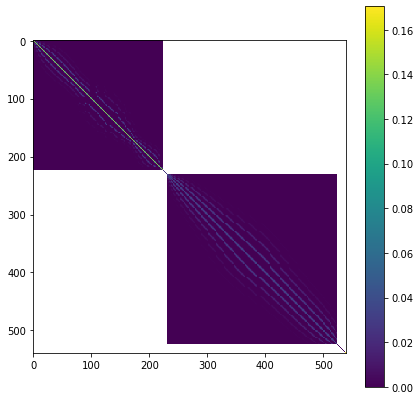

In [20]:
cov = pf.build_prior()
x = cov.x.copy()
x[x==0.0] = np.NaN
fig,ax = plt.subplots(1,1,figsize=(7,7))
g = ax.imshow(x)
plt.colorbar(g)

In [21]:
pst.control_data.noptmax = -1 # FOR JACOBIAN
pst.write(os.path.join(template_ws,"{}.pst".format(case)))

noptmax:-1, npar_adj:539, nnz_obs:222


In [22]:
#pyemu.os_utils.run("..\..\pestpp-glm.exe {}".format(case),cwd="template")

In [24]:
m_d = "master_glm"

pyemu.os_utils.start_workers(template_ws,"../../pestpp-glm.exe","{}.pst".format(case),num_workers=10,worker_root=".",master_dir=m_d)

In [25]:
t_d ="master_glm"
case = "3D_test"
pst = pyemu.Pst(os.path.join(t_d,"{}.pst".format(case)))
pst.write_par_summary_table(filename="none")

pst.svd_data.eigthresh = 5e-7
pst.control_data.noptmax = 7 # number of iterations (should be set to a great value (50))
pst.pestpp_options["n_iter_base"] = -1
pst.pestpp_options["n_iter_super"] = 4
pst.pestpp_options["glm_num_reals"] = 50 # how many draws
pst.pestpp_options["parcov"] = "{}.prior.cov".format(case)
pst.pestpp_options["base_jacobian"] = "{}.jcb".format(case)
pst.write(os.path.join(t_d,"{}.pst".format(case)))

# DO the inversion
m_d = "master_glm_run"
pyemu.os_utils.start_workers(t_d,"../../pestpp-glm.exe","{}.pst".format(case),num_workers=10,worker_root=".",
                             master_dir=m_d)

noptmax:7, npar_adj:539, nnz_obs:222
